#Resolución SDO

# Sistema de Lorenz: Modelo caótico de dinámica atmosférica 🔄🌀

El sistema de **Lorenz** es un conjunto de ecuaciones diferenciales ordinarias no lineales que modela la convección térmica en la atmósfera. Introducido por Edward Lorenz en 1963 como una simplificación del modelo de circulación atmosférica.

Este sistema está formado por tres ecuaciones acopladas:
$$
\begin{cases}
\displaystyle\frac{dx}{dt} &= \sigma (y - x), \\
\displaystyle\frac{dy}{dt} &= x(\rho - z) - y, \\
\displaystyle\frac{dz}{dt} &= xy - \beta z,\\
\end{cases}
$$

donde:
- $ x $ representa la velocidad de convección,
- $ y$ la diferencia de temperatura entre las corrientes ascendentes y descendentes,
- $ z $ la desviación de la temperatura vertical,
- y los parámetros $ \sigma $, $ \rho $, y $ \beta $ son constantes físicas relacionadas con la viscosidad del fluido y la diferencia de temperatura.

Las condiciones iniciales son:
$$x(0)=1.0,\quad y(0)=1.0,\quad z(0)=1.0.$$

El sistema presenta un comportamiento **altamente sensible a las condiciones iniciales**, característica del caos determinista. Su solución en el espacio tridimensional forma una figura famosa conocida como el **atractor de Lorenz**, con forma de mariposa.

<img src="https://raw.githubusercontent.com/leflores-fisi/lorenz-attractor/main/imgs/lorenz_butterfly.jpg" width=180 heigth=180>

Aproximamos la solución del sistema de Lorenz por **ajuste** usando redes neuronales artificiales.

A continuación, definimos el código utilizando *Pytorch*:

In [1]:
# Importar librerias
import numpy as np                 # Manejo de vectores y matrices (arrays)
import torch                       # Biblioteca principal para cálculo tensorial y redes neuronales
import torch.nn as nn              # Componentes para construir redes neuronales (capas, activaciones)
import torch.optim as optim        # Algoritmos de optimización para ajustar parámetros de la red
import torch.nn.init as init       # Métodos para inicializar pesos de redes neuronales
import torch.autograd as grad      # Cálculo automático de derivadas (gradientes)
import matplotlib.pyplot as plt    # Herramientas para visualización gráfica de resultados
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import time                        # Funciones para medir tiempos de ejecución
import math                        # Funciones matemáticas elementales (trigonometría, exponenciales, etc.)
import torch.nn.functional as F    # Funciones matemáticas sin parámetros para redes (activaciones, pérdidas)
from scipy.integrate import solve_ivp

###Aproximacion solve_ivp

In [2]:
# Parámetros Lorenz
sigma, rho, beta = 10.0, 28.0, 8/3

# Definición del sistema Lorenz para solve_ivp (t, state, ...)
def solve_lorenz(t, state, sigma, rho, beta):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

# Condiciones iniciales
initial_state = [1., 1., 1.]

# Intervalo de tiempo y puntos donde evaluar la solución
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], 3000)

In [3]:
# Resolver sistema con solve_ivp
sol = solve_ivp(solve_lorenz, t_span, initial_state, args=(sigma, rho, beta), t_eval=t_eval)

xs = sol.y[0]
ys = sol.y[1]
zs = sol.y[2]

#### Gráfica 2D

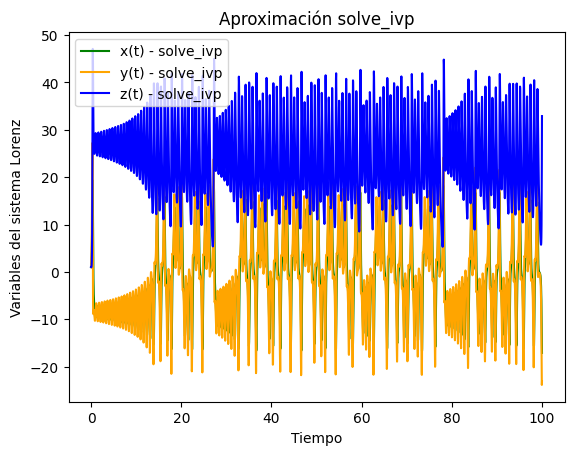

In [ ]:
plt.figure()
plt.plot(sol.t, sol.y[0], color='green', label="x(t) - solve_ivp")
plt.plot(sol.t, sol.y[1], color='orange', label="y(t) - solve_ivp")
plt.plot(sol.t, sol.y[2], color='blue', label="z(t) - solve_ivp")

plt.legend()
plt.title(f'Aproximación solve_ivp')
plt.xlabel("Tiempo")
plt.ylabel("Variables del sistema Lorenz")
plt.show()

#### Gráfica 3D

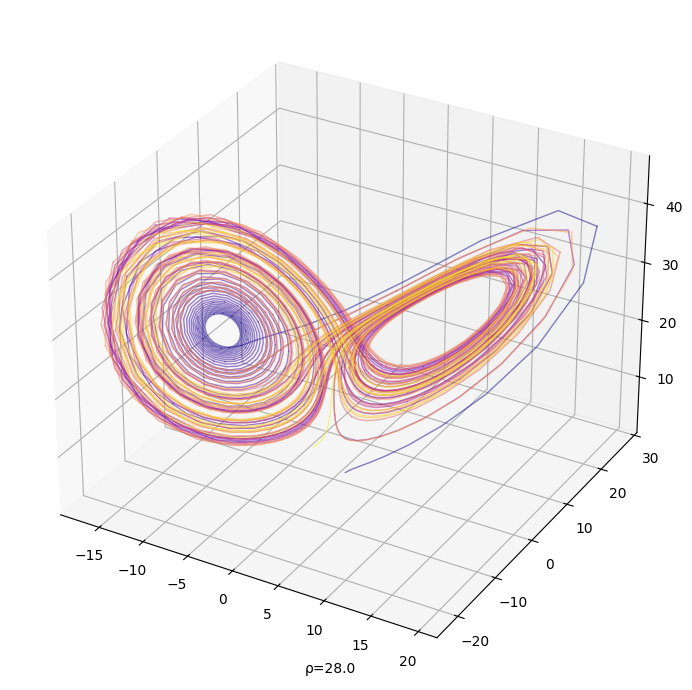

In [7]:
# Colormap para la gráfica
cmap = plt.cm.plasma

# Función para graficar el atractor coloreado
def lorenz_attractor(state0, parameters, ax=None, text_offset=0.01):
    sigma, rho, beta = parameters
    n = len(sol.t)
    xs = sol.y[0]
    ys = sol.y[1]
    zs = sol.y[2]

    if ax is None:
        ax = plt.figure(figsize=(7, 8)).add_subplot(projection='3d')

    s = 10
    for i in range(0, n - s, s):
        ax.plot(xs[i:i+s+1], ys[i:i+s+1], zs[i:i+s+1], color=cmap(i/n), alpha=0.5, lw=1)

    ax.text2D(0.44, text_offset, f"ρ={rho}", transform=ax.transAxes)
    ax.figure.tight_layout()
    return ax.figure

# Graficar atractor
lorenz_attractor(initial_state, (sigma, rho, beta)).show()

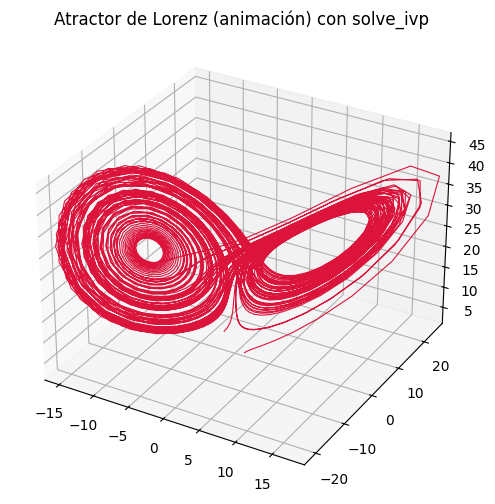

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# Configuración del gráfico 3D para animación
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
line, = ax.plot([], [], [], lw=0.8, color='crimson')
ax.set_xlim((min(xs), max(xs)))
ax.set_ylim((min(ys), max(ys)))
ax.set_zlim((min(zs), max(zs)))
ax.set_title("Atractor de Lorenz (animación) con solve_ivp")

# Inicialización de la animación
def init():
    line.set_data([], [])
    line.set_3d_properties([])
    return line,

# Actualización del frame de la animación
def update(frame):
    line.set_data(xs[:frame], ys[:frame])
    line.set_3d_properties(zs[:frame])
    return line,

# Crear la animación
ani = FuncAnimation(fig, update, frames=range(0, len(t_eval), 10), init_func=init,
                    blit=False, interval=10, repeat=False)

# Guardar animación en MP4 (requiere ffmpeg instalado)
ani.save('sistemaLorenz.mp4', writer='ffmpeg', fps=20)

# Mostrar animación
plt.show()

# Descargar el video en Google Colab
from google.colab import files
files.download('sistemaLorenz.mp4')

###Aproximación PINN

In [27]:
# Fijamos la semilla
torch.manual_seed(1234)
np.random.seed(1234)


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


#### Definición red neuronal

In [36]:
# Definición de Red Neuronal de Propagación Adelante (Feedforward)

class PINN(nn.Module):                                           # Clase PINN es una subclase de nn.Module

    def __init__(self, input_size, hidden_size, output_size):    # Constructor que se ejecuta cuando se crea una instancia de la clase PINN
                                                                 # Este método inicializa las capas de la red neuronal
        super(PINN, self).__init__()                             # Llama al constructor de la clase base nn.Module


        # Capas de la red neuronal (4 capas lineales: nn.Linear)

        # Estas capas representan las conexiones ponderadas entre las neuronas de capas consecutivas.
        #  nn.Linear(input_size, hidden_size)
        #  input_size : es la cantidad de entradas (neuronas en la capa anterior)
        #  hidden_size: la cantidad de salidas (neuronas en la capa actual)
        # Capa lineal => Salida = Entradas × Pesos + Sesgo

        # Capa 1: Recibe input_size características como entrada y produce hidden_size características como salida
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Capa 2: Entrada con hidden_size características, salida con hidden_size características
        self.fc2 = nn.Linear(hidden_size, hidden_size)

        # Capa 3: Entrada con hidden_size características, salida con hidden_size características
        self.fc3 = nn.Linear(hidden_size, hidden_size)

        # Capa 4: Entrada con hidden_size características, salida con hidden_size características
        self.fc4 = nn.Linear(hidden_size, hidden_size)

        # Capa 5: Entrada con hidden_size características, salida con hidden_size características
        self.fc5 = nn.Linear(hidden_size, hidden_size)

        # Capa 6: Entrada con hidden_size características, salida con hidden_size características
        self.fc6 = nn.Linear(hidden_size, hidden_size)

        # Capa 7: Entrada con hidden_size características, salida con hidden_size características
        self.fc7 = nn.Linear(hidden_size, hidden_size)

        # Capa 8: Entrada con hidden_size características, salida con 3 característica
        self.fc8 = nn.Linear(hidden_size, output_size)

        # Inicialización de pesos (I): Random Initialization
        # Inicializar los pesos de las capas con valores aleatorios: distribución normal o uniforme
        #
        # nn.init.normal_(layer.weight, mean=0.0, std=0.01)  # Distribución normal
        # o
        # nn.init.uniform_(layer.weight, a=0, b=1)           # Distribución uniforme

        # Inicialización de pesos (II): Xavier/Glorot Initialization
        # Diseñada para su uso con funciones de activación como la tangente hiperbólica o la función logística (sigmoid)
        # Ayuda a mantener una varianza constante a través de las capas
        ## Sale mejor en este ejemplo que sin dicha inicializacion
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.xavier_normal_(self.fc5.weight)
        nn.init.xavier_normal_(self.fc6.weight)
        nn.init.xavier_normal_(self.fc7.weight)
        nn.init.xavier_normal_(self.fc8.weight)


        # Inicialización de pesos (III):  LeCun Initialization:
        # Inicialización propuesta por LeCun para funciones de activación como la tangente hiperbólica
        # nn.init.normal_(layer.weight, mean=0, std=np.sqrt(1 / layer.weight.shape[0]))
        # init.normal_(self.fc1.weight, mean=0, std=np.sqrt(1 / self.fc1.weight.shape[0]))
        # init.normal_(self.fc2.weight, mean=0, std=np.sqrt(1 / self.fc2.weight.shape[0]))
        # init.normal_(self.fc3.weight, mean=0, std=np.sqrt(1 / self.fc3.weight.shape[0]))
        # init.normal_(self.fc4.weight, mean=0, std=np.sqrt(1 / self.fc4.weight.shape[0]))
        # init.normal_(self.fc5.weight, mean=0, std=np.sqrt(1 / self.fc5.weight.shape[0]))
        # init.normal_(self.fc6.weight, mean=0, std=np.sqrt(1 / self.fc6.weight.shape[0]))
        # init.normal_(self.fc7.weight, mean=0, std=np.sqrt(1 / self.fc7.weight.shape[0]))
        # init.normal_(self.fc8.weight, mean=0, std=np.sqrt(1 / self.fc8.weight.shape[0]))

    def forward(self, x):
       # En este caso, el método forward toma la entrada x y la pasa a través de las capas fc1, fc2, fc3, fc4, fc5, fc6 y fc7
       # utilizando la función de activación tangente hiperbólica (torch.tanh) después de las 7 primeras capas.
       # La última capa (fc8) no tiene una función de activación
       x = torch.tanh(self.fc1(x))
       x = torch.tanh(self.fc2(x))
       x = torch.tanh(self.fc3(x))
       x = torch.tanh(self.fc4(x))
       x = torch.tanh(self.fc5(x))
       x = torch.tanh(self.fc6(x))
       x = torch.tanh(self.fc7(x))
       x = self.fc8(x)             # No aplicamos función de activación en la última capa fc5

       # Aplicacion a la sigmoide
       #x = torch.sigmoid(self.fc1(x))
       #x = torch.sigmoid(self.fc2(x))
       #x = torch.sigmoid(self.fc3(x))
       #x = torch.sigmoid(self.fc4(x))
       #x = self.fc5(x)

       return x

#### Datos de entrenamiento

In [37]:
print(sol.t.shape)
print(sol.y.shape)

t = sol.t[::1]
y = sol.y[::1]
t = torch.Tensor(sol.t).view(-1,1)       # (N, 1)
y = torch.Tensor(sol.y.T)
t.shape
y.shape
y

(3000,)
(3, 3000)


tensor([[  1.0000,   1.0000,   1.0000],
        [  1.1315,   1.8933,   0.9635],
        [  1.5032,   2.9828,   0.9831],
        ...,
        [-11.1921, -20.6174,  14.7494],
        [-14.4090, -23.8748,  22.7103],
        [-17.1108, -23.1253,  32.8976]])

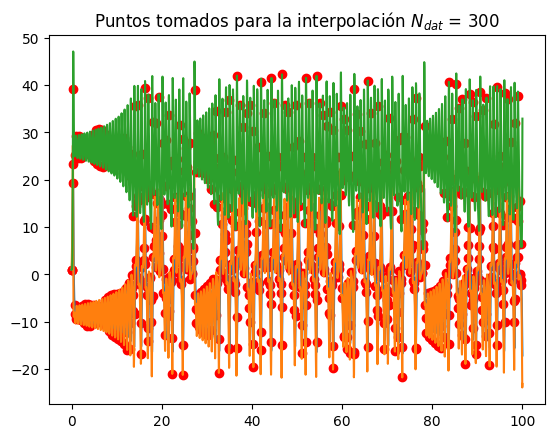

In [38]:
N = 3000
print_freq = 2000 # imprimir cada epoca
k = 300
#k = 180
#k = 14
#k = 100
n = math.ceil(N/k) # redondeo hacia arriba
n


# Vamos a tomar 26 datos para el entrenamiento

#t_data = t[::119]
#y_data = y[::119]
# Tomamos 11, peor que 26
#t_data = t[::300]
#y_data = y[::300]

# Tomamos k
t_data = t[::n]
y_data = y[::n]


t_data.shape, y_data.shape
#y_data
#t.shape, y.shape

(torch.Size([21, 1]), torch.Size([21, 2]))

plt.figure()
plt.plot(t,y)
plt.scatter(t_data,y_data[:,0], c="red")
plt.scatter(t_data,y_data[:,1], c="red")
plt.scatter(t_data,y_data[:,2], c="red")
plt.title(f"Puntos tomados para la interpolación $N_{{dat}}$ = {len(y_data)}")
plt.show()

####Entrenamiento red neuronal

In [39]:
# Función de entrenamiento
def train(model, optimizer,loss_fn, t_data, y_data, num_epochs):

  learning_rates = []                             # Lista --> almacena los learning rates en cada iteración/época
  loss_history = []                               # Lista --> almacena la pérdida en cada época


  for epoca in range(num_epochs):                 # Bucle de entrenamiento

    # Calcular las predicciones de la red y las derivadas
    model.train()                                 # Activación del modo de entrenamiento de la red

    y = model(t_data)                             # Predicciones de la red


    # Calcular la pérdida entre predicciones y datos reales
    loss = loss_fn(y, y_data)

    # Optimización
    optimizer.zero_grad()                         # Se ponen a cero los gradientes acumulados en los tensores del modelo
    loss.backward()                               # Se realiza la retropropagación backward
    optimizer.step()                              # Se actualizan los parámetros del modelo mediante el optimizador (optimizer)

    loss_history.append(loss.item())              # Almacenamiento de la pérdida (error)


    current_lr = optimizer.param_groups[0]['lr']  # Obtiene learning rate actual
    learning_rates.append(current_lr)             # Almacenamiento del learning rate

    # Imprimir el progreso
    if (epoca + 1) % print_freq == 0:
      print(f'Epoch [{epoca+1}/{num_epochs}], Total Loss: {loss.item()}')

  return loss_history, learning_rates, y         # Lista de la pérdida y el lerning rate al final del entrenamiento

#### Hiperparámetros de la red

In [42]:
# Instancia del modelo y del optimizador

# Creación del modelo con los parámetros definidos
# model = PINN(input_size, hidden_size, output_size)
# Necesitamos como datos de entrada:
# - input_size
# - hidden_size
# - output_size

# Parámetros del modelo
input_size = 1            # Número de entradas de la red
hidden_size = 200          # Número de neuronas en la capa oculta
#hidden_size = 60         # Opciones alternativas del tamaño de la capa oculta
#hidden_size = 200
output_size = 3           # Número de salidas de la red

# Tasa de aprendizaje
learnig_rate = 0.001
# learnig_rate = 0.01

model = PINN(input_size, hidden_size, output_size)

# Definición del optimizador para la actualización de los pesos de la red
optimizer = optim.Adam(model.parameters(), lr = learnig_rate)

# Función de pérdida para calcular el error de la red
loss_fn = nn.MSELoss()

start_time = time.time()   # Tiempo de inicio

# Número de iteraciones:
num_epoch = 30000
#num_epoch = 40000         # Otras opciones
#num_epoch = 15000
#num_epoch = 35000
#num_epoch = 48000
#num_epoch = 22000
#num_epoch = 10000
#num_epoch = 1000000       # Muchísimas épocas (no recomendable en muchos casos)
#num_epoch = 5000

# Entrenamos el modelo utilizando la función de entrenamiento
loss_history, learning_rates, y = train(model, optimizer, loss_fn,t_data, y_data, num_epoch)

end_time = time.time()     # Tiempo de finalización

# Calculamos el tiempo transcurrido durante el entrenamiento
elapsed_time = end_time - start_time
print(f' ')
print(f'Tiempo de ejecución: {elapsed_time} segundos')

Epoch [2000/30000], Total Loss: 65.58477783203125
Epoch [4000/30000], Total Loss: 59.99241638183594
Epoch [6000/30000], Total Loss: 53.456031799316406
Epoch [8000/30000], Total Loss: 49.354434967041016
Epoch [10000/30000], Total Loss: 52.679630279541016
Epoch [12000/30000], Total Loss: 44.31521224975586
Epoch [14000/30000], Total Loss: 53.11042404174805
Epoch [16000/30000], Total Loss: 51.60862350463867
Epoch [18000/30000], Total Loss: 55.57598114013672
Epoch [20000/30000], Total Loss: 51.61175537109375
Epoch [22000/30000], Total Loss: 50.57114028930664
Epoch [24000/30000], Total Loss: 48.993045806884766
Epoch [26000/30000], Total Loss: 53.51363754272461
Epoch [28000/30000], Total Loss: 48.999515533447266
Epoch [30000/30000], Total Loss: 49.128074645996094
 
Tiempo de ejecución: 443.3968331813812 segundos


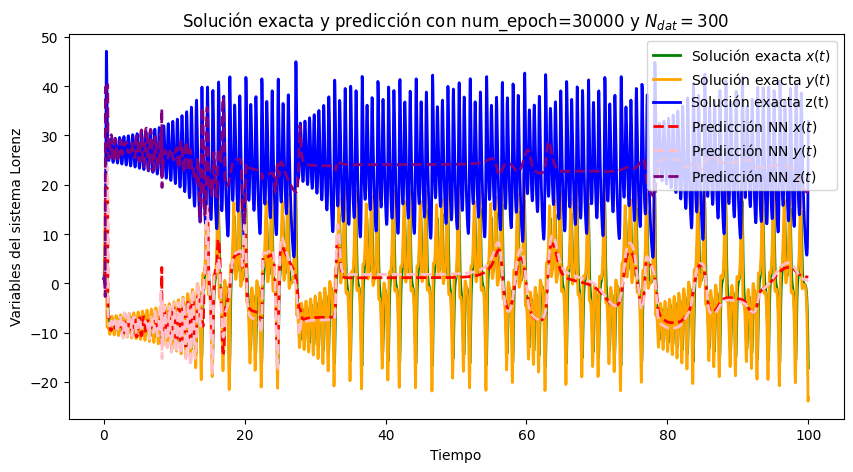

In [45]:
yh = model(t).detach()
yh
yh.shape

plt.figure(figsize=(10,5))
plt.plot(sol.t, sol.y[0,:], color='green', linewidth=2, label='Solución exacta $x(t)$')
plt.plot(sol.t, sol.y[1, :], color='orange', linewidth=2, label='Solución exacta $y(t)$')
plt.plot(sol.t, sol.y[2,:], color= 'blue', linewidth=2, label='Solución exacta z(t)')
plt.plot(sol.t, yh[:,0], linestyle = '--', color='red', linewidth=2, label="Predicción NN $x(t)$")
plt.plot(sol.t, yh[:,1], linestyle = '--', color='pink', linewidth=2, label="Predicción NN $y(t)$")
plt.plot(sol.t, yh[:,2], linestyle = '--', color='purple', linewidth=2, label="Predicción NN $z(t)$")
plt.legend()
plt.title(f"Solución exacta y predicción con num_epoch={num_epoch} y $N_{{dat}} = {len(y_data)}$")
plt.xlabel("Tiempo")
plt.ylabel("Variables del sistema Lorenz")
plt.show()

#### Error entrenamiento y evolución learning rate

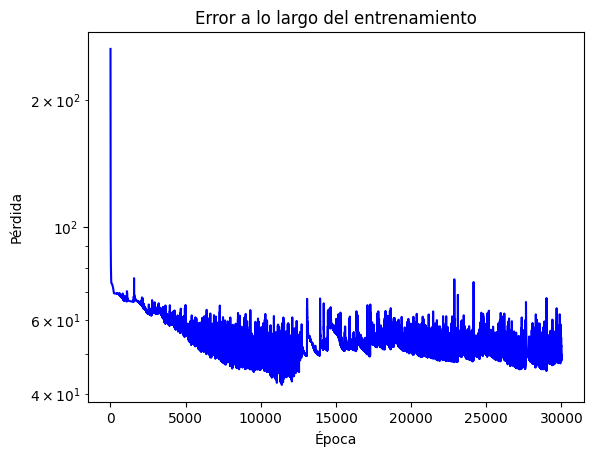

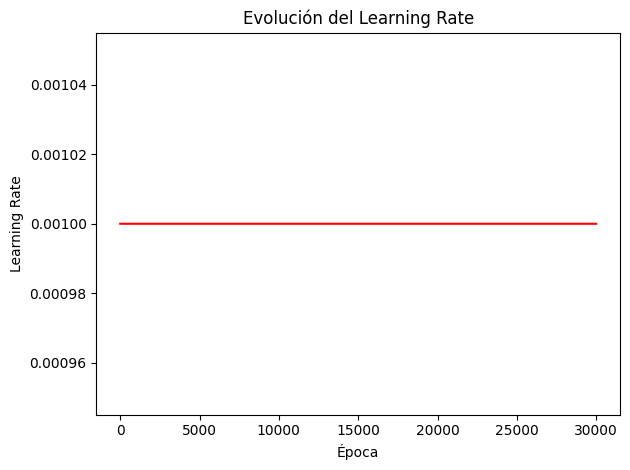

In [46]:
# Crear una figura con dos subgráficas
plt.figure(1)
# Graficar la evolución de la pérdida
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Error a lo largo del entrenamiento')
plt.yscale('log')            # escala logarítmica se utiliza generalmente cuando los valores de la pérdida varían en un rango amplio

plt.figure(2)
# Graficar la evolución del learning rate
plt.plot(range(1, len(loss_history) + 1), learning_rates, label='Learning Rate', color='red')
plt.xlabel('Época')
plt.ylabel('Learning Rate')
plt.title('Evolución del Learning Rate')


# Ajustar el diseño y mostrar la gráfica
plt.tight_layout()
plt.show()